# Installations

In [17]:
# !pip install pandas scikit-learn tensorflow nltk

# Imports

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import re
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import SimpleRNN, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Fatima
[nltk_data]     Azfar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Dataset

In [19]:
df = pd.read_csv('urdu-sentiment-corpus-v1.tsv', delimiter='\t')
df

,Tweet,Class
0,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,P
1,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,N
2,ٹویٹر کا خیال کیسے آیا ؟,O
3,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",P
4,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,P
...,...,...
995,اُس آدمی نے اِس سالار کو کافی معقول ٹپ دی ہے ۔,P
996,چچا غالب کی روح سے معذرت کے ساتھہم نے مانا کہ ...,P
997,واہ جناب واہ! اچھی رہی۔ جناب خود کو فرشتہ سمجو...,P
998,اسلام آباد :پی اے ٹی کا دھرنا ختم، صفائی کے کا...,P


# Data Exploration

In [20]:
df['Class'].value_counts()

Class
N    499
P    480
O     20
Name: count, dtype: int64

In [21]:
for i in df[df['Class'] == 'O']['Tweet']:
    print(i)

 ٹویٹر کا خیال کیسے آیا ؟
پاکستان کی ٹیم میں ،احمد شہزاد، محمد حفیظ، اظہر علی، یونس خان، مصباح الحق،اسد شفیق، سرفراز احمد، ذوالفقار بابر، عمران خان، یاسر شاہ، اور راحت علی شامل،
 ایک گھنٹے بعد کیا کرو گی؟
ایک آدمی نے اپنے بیٹے کو سمجھانے کے لیے اسے ایک شیشے کے سامنے کھڑا کر کے پوچھا بیٹا اس شیشے میں تمہیں کیا نظر آ۔۔۔ 
س ٹیسٹ کے امپائرز انگلینڈ کے کیٹل برو اور جنوبی افریقہ کے ایراسمس ہیں ۔ سری لنکا کے رنجن مدوگالے میچ ریفری ہیں ۔
دبئی ٹیسٹ میچ میں پاکستان کی پہلے بیٹنگ 
اگر ٹرین کی رفتار 120 کلومیٹر فی گھنٹہ ہو، تو 2 منٹ کی وڈیو میں ٹرین کی تقریباً لمبائی کیا ہوسکتی ہے ؟؟؟ 
بچے غیر سیاسی ہوتے ہیں 
سوال: چائے کا اصلی وطن کون سا ہے ؟ اپنا جواب اس نمبر پہ دیں 
انصافیوں کے ٹرینڈ کا احوال: 1۔ اوریجنل ٹرینڈ = 20۔5 %2۔ ریٹویٹس = 75۔7 %3۔ ریپلائیز = 3۔8 %
 وہ انکو نہیں آتا :)
لاہور: اجلاس کی صدارت خواجہ حسان نے کی۔
 سر جی ! ترجمہ ؟؟
کپتان صاحب وہ جو کے لئے چندہ لیا تھا خدا کے لئے اتنا ہی بتا دو کہ کتنے اسکول بنائے کہاں تک پہنچا؟ چندے سے انقلاب۔۔۔
 فوڈ کے نام پر آملیٹ اور اسکی کیا ترکیب پوچھنی 

### The label 'O' consists of only 20 sentences in the entire dataset thus I will be dropping these rows as I want to focus on positive and negative sentiment only.

In [22]:
df = df.drop(df[df['Class'] == 'O'].index)

### Also dropping the rows where the Class is null

In [23]:
df.isnull().sum()

Tweet    0
Class    1
dtype: int64

In [24]:
df.dropna(subset=['Class'], inplace=True)

In [25]:
df.isnull().sum()

Tweet    0
Class    0
dtype: int64

# Data Preparation

In [26]:

# Define a function to clean tweets
def clean_tweet(tweet):
    # Keep Urdu characters, hashtags, mentions, and whitespace
    # Urdu characters range: [\u0600-\u06FF\u0750-\u077F]
    cleaned_tweet = re.sub(r"[^\u0600-\u06FF\u0750-\u077F#@ ]", "", tweet)
    return cleaned_tweet

# Clean the tweets in the 'Tweet' column
df['Cleaned_Tweet'] = df['Tweet'].apply(clean_tweet)

# Tokenization of the cleaned tweets
df['Tokenized'] = df['Cleaned_Tweet'].apply(word_tokenize)

# Initialization of the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Tokenized'])

# Converting the text to sequences
sequences = tokenizer.texts_to_sequences(df['Tokenized'])

# Padding the sequences to have uniform length
max_seq_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

# Mapping the textual labels to numeric values
label_mapping = {'P': 1, 'N': 0}
df['Class'] = df['Class'].map(label_mapping)

# Converting the 'Class' column to a numeric type (int) after mapping
df['Class'] = df['Class'].astype(int)

labels = df['Class'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.25, random_state=42
)

# RNN

Training with 2 layers and 0.3 dropout rate




Epoch 1/50


19/19 [==============================] - 4s 51ms/step - loss: 0.9470 - accuracy: 0.5026 - val_loss: 0.9285 - val_accuracy: 0.4490
Epoch 2/50
19/19 [==============================] - 0s 23ms/step - loss: 0.6845 - accuracy: 0.7819 - val_loss: 1.2261 - val_accuracy: 0.5238
Epoch 3/50
19/19 [==============================] - 0s 18ms/step - loss: 0.3520 - accuracy: 0.9574 - val_loss: 1.5867 - val_accuracy: 0.4558
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.9168 - accuracy: 0.4449
Test Accuracy: 0.44489794969558716
Training with 2 layers and 0.7 dropout rate
Epoch 1/50
19/19 [==============================] - 3s 43ms/step - loss: 1.0632 - accuracy: 0.4821 - val_loss: 0.9569 - val_accuracy: 0.4694
Epoch 2/50
19/19 [==============================] - 0s 20ms/step - loss: 0.9703 - accuracy: 0.5690 - val_loss: 1.1236 - val_accuracy: 0.4354
Epoch 3/50
19/19 [==============================] - 0s 18ms/step - loss: 0.8349 - accuracy: 0.6746 - val_loss: 1.593

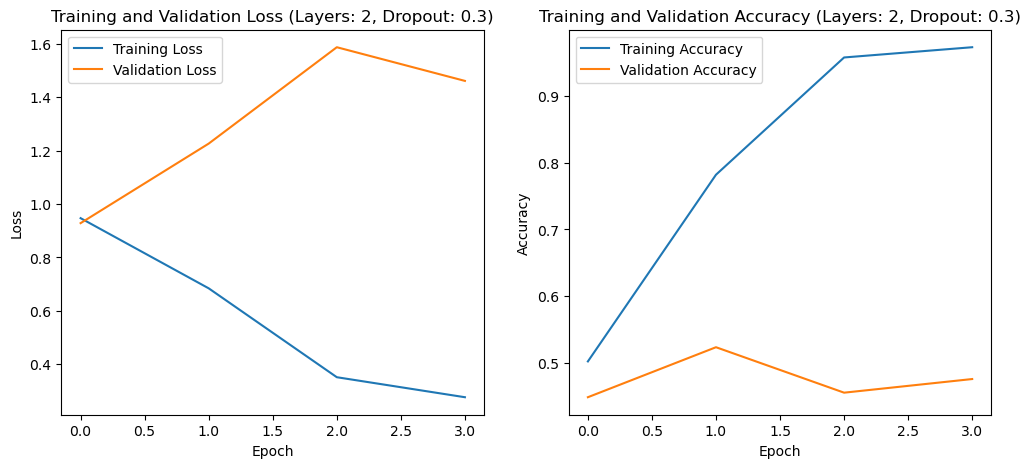

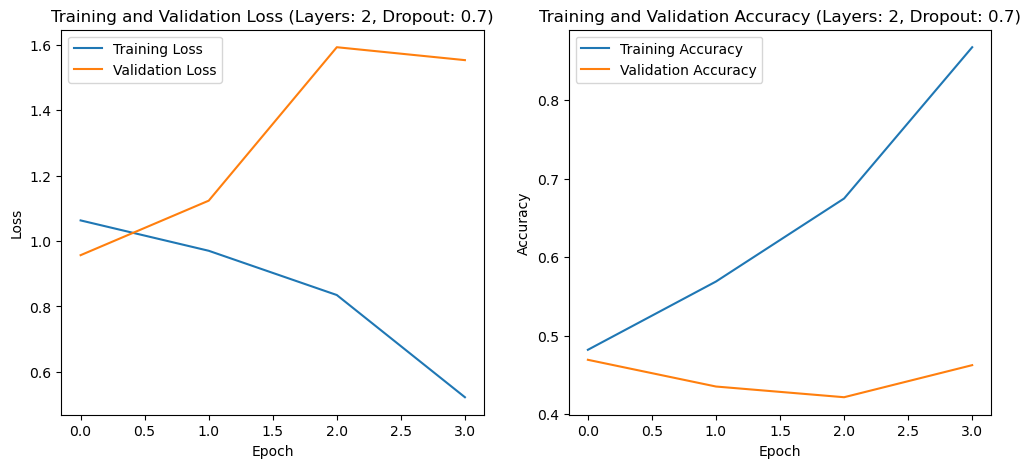

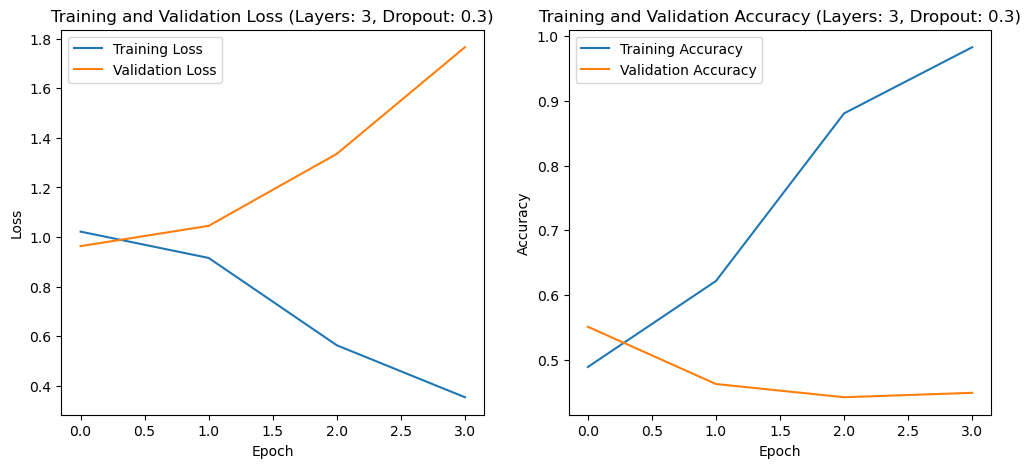

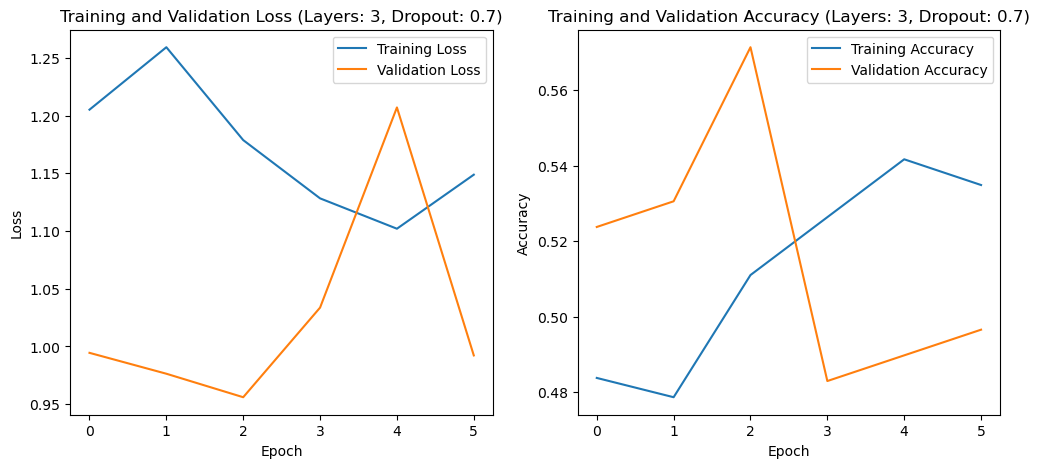

In [27]:
# Model configuration
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the reserved 0 index
embed_dim = 128  # Size of the embedding vector
l2_reg = 0.001  # L2 regularization factor

# Hyperparameter sets
layers_options = [2, 3]
dropout_options = [0.3, 0.7]

best_acc = 0
best_params = {}
history_records = []

# Define an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for layers in layers_options:
    for dropout_rate in dropout_options:
        print(f"Training with {layers} layers and {dropout_rate} dropout rate")

        # Definition of the RNN model
        model = Sequential()
        model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_seq_length))
        
        for i in range(layers):
            return_sequences = i < layers - 1
            rnn_units = 128 if i == 0 else 64
            model.add(SimpleRNN(rnn_units, return_sequences=return_sequences, kernel_regularizer=l2(l2_reg)))
            model.add(Dropout(dropout_rate))
        
        model.add(Dense(1, activation='sigmoid'))

        # Compilation of the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Training of the model
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

        # Record the history
        history_records.append((layers, dropout_rate, history))

        # Evaluation of the model on the test data
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print(f"Test Accuracy: {test_acc}")

        # Check if this is the best accuracy
        if test_acc > best_acc:
            best_acc = test_acc
            best_params = {'layers': layers, 'dropout': dropout_rate}

print(f"Best performing model: {best_params} with accuracy {best_acc}")

for layers, dropout_rate, history in history_records:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training and Validation Loss (Layers: {layers}, Dropout: {dropout_rate})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Training and Validation Accuracy (Layers: {layers}, Dropout: {dropout_rate})")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# GRU

Training with 2 layers and 0.3 dropout rate
Epoch 1/50
19/19 [==============================] - 7s 101ms/step - loss: 0.9095 - accuracy: 0.4991 - val_loss: 0.8749 - val_accuracy: 0.4490
Epoch 2/50
19/19 [==============================] - 1s 32ms/step - loss: 0.8423 - accuracy: 0.5094 - val_loss: 0.8158 - val_accuracy: 0.4490
Epoch 3/50
19/19 [==============================] - 1s 35ms/step - loss: 0.7960 - accuracy: 0.4906 - val_loss: 0.7770 - val_accuracy: 0.4490
Epoch 4/50
19/19 [==============================] - 1s 33ms/step - loss: 0.7663 - accuracy: 0.5162 - val_loss: 0.7523 - val_accuracy: 0.4490
Epoch 5/50
19/19 [==============================] - 1s 32ms/step - loss: 0.7431 - accuracy: 0.5009 - val_loss: 0.7362 - val_accuracy: 0.4490
Epoch 6/50
19/19 [==============================] - 1s 32ms/step - loss: 0.7292 - accuracy: 0.5026 - val_loss: 0.7274 - val_accuracy: 0.4490
Epoch 7/50
19/19 [==============================] - 1s 34ms/step - loss: 0.7190 - accuracy: 0.5128 - val_loss

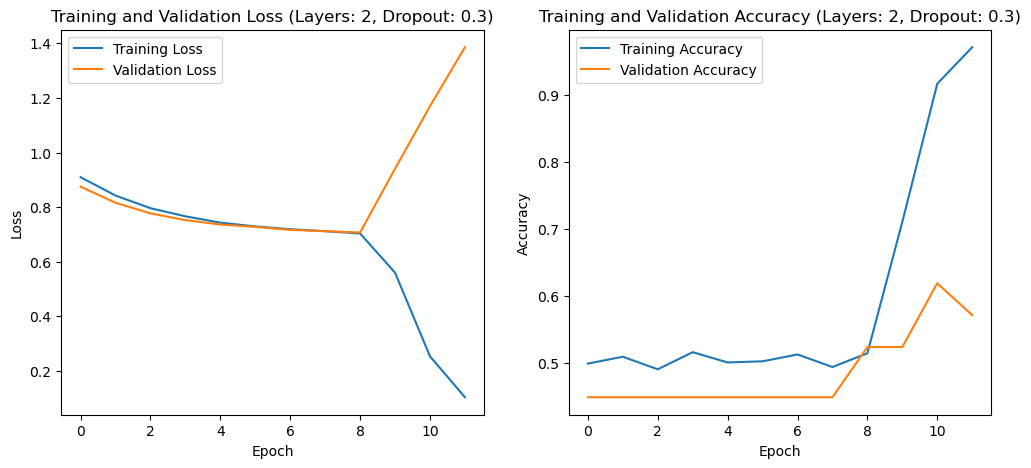

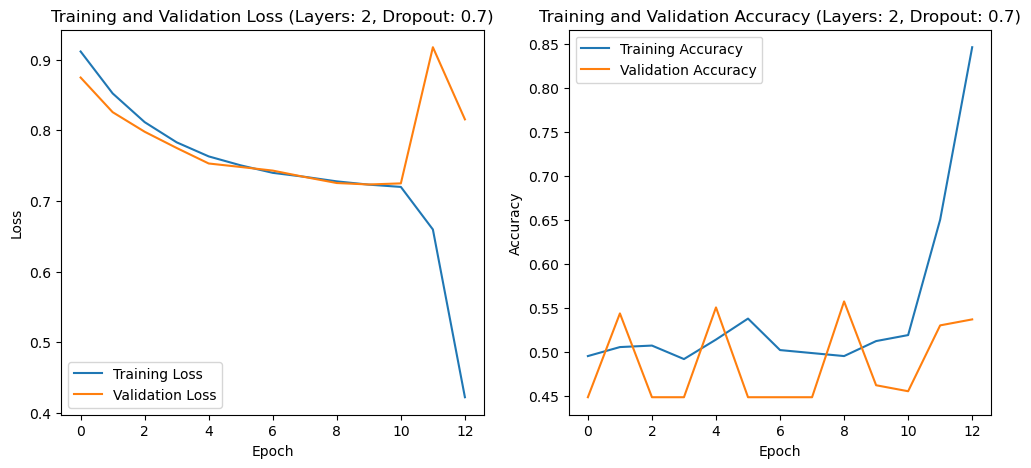

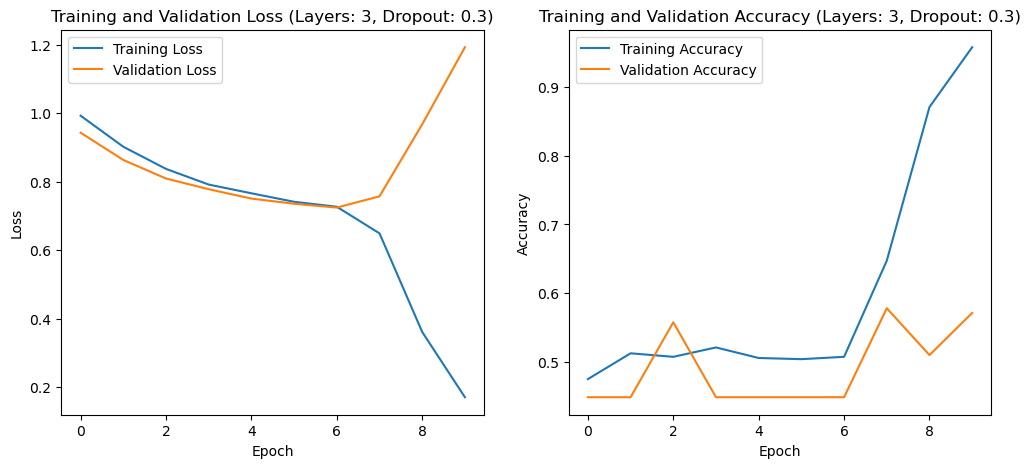

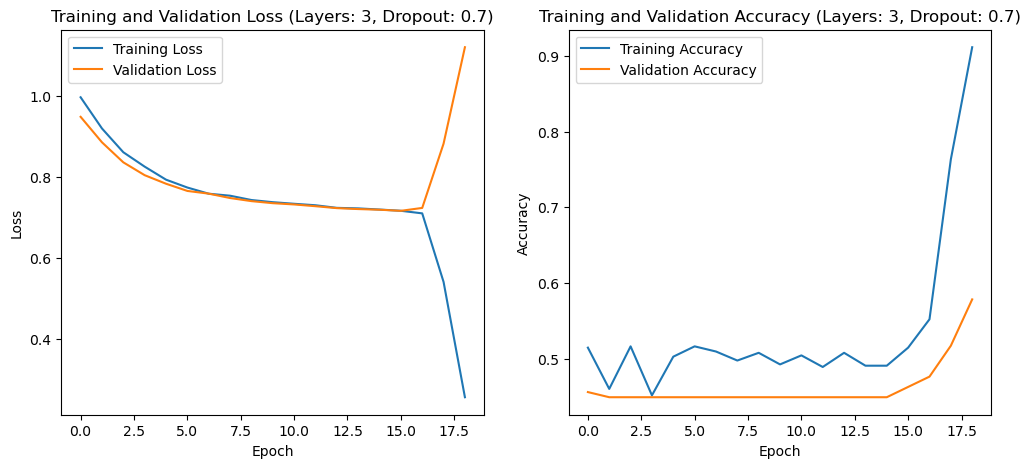

In [28]:
# Model configuration
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the reserved 0 index
embed_dim = 128  # Size of the embedding vector
l2_reg = 0.001  # L2 regularization factor

# Hyperparameter sets
layers_options = [2, 3]
dropout_options = [0.3, 0.7]

best_acc = 0
best_params = {}
history_records = []

# Define an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for layers in layers_options:
    for dropout_rate in dropout_options:
        print(f"Training with {layers} layers and {dropout_rate} dropout rate")

        model = Sequential()
        model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_seq_length))
        model.add(GRU(64, return_sequences=(layers > 1), kernel_regularizer=l2(l2_reg)))
        model.add(Dropout(dropout_rate))
        
        for i in range(1, layers):
            return_sequences = i < layers - 1
            model.add(GRU(64, return_sequences=return_sequences, kernel_regularizer=l2(l2_reg)))
            model.add(Dropout(dropout_rate))
        
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

        history_records.append((layers, dropout_rate, history))

        test_loss, test_acc = model.evaluate(X_test, y_test)
        print(f'Test Accuracy: {test_acc}')

        if test_acc > best_acc:
            best_acc = test_acc
            best_params = {'layers': layers, 'dropout': dropout_rate}

print(f"Best performing model: {best_params} with accuracy {best_acc}")

for layers, dropout_rate, history in history_records:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# LSTM

Training with 2 layers and 0.5 dropout rate
Epoch 1/50
10/10 [==============================] - 8s 194ms/step - loss: 3.9167 - accuracy: 0.4804 - val_loss: 3.6142 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 0s 39ms/step - loss: 3.4148 - accuracy: 0.5077 - val_loss: 3.1421 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 0s 42ms/step - loss: 2.9607 - accuracy: 0.5315 - val_loss: 2.7132 - val_accuracy: 0.5442 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 0s 44ms/step - loss: 2.5532 - accuracy: 0.5162 - val_loss: 2.3339 - val_accuracy: 0.4558 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 0s 44ms/step - loss: 2.1850 - accuracy: 0.5332 - val_loss: 2.0000 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 6/50
10/10 [==============================] - 0s 44ms/step - loss: 1.6870 - accuracy: 0.8382 - val_loss: 2.1572 - val_accuracy: 0.5646 - lr: 0.0010
Epoch 7/50
10/10 [=============

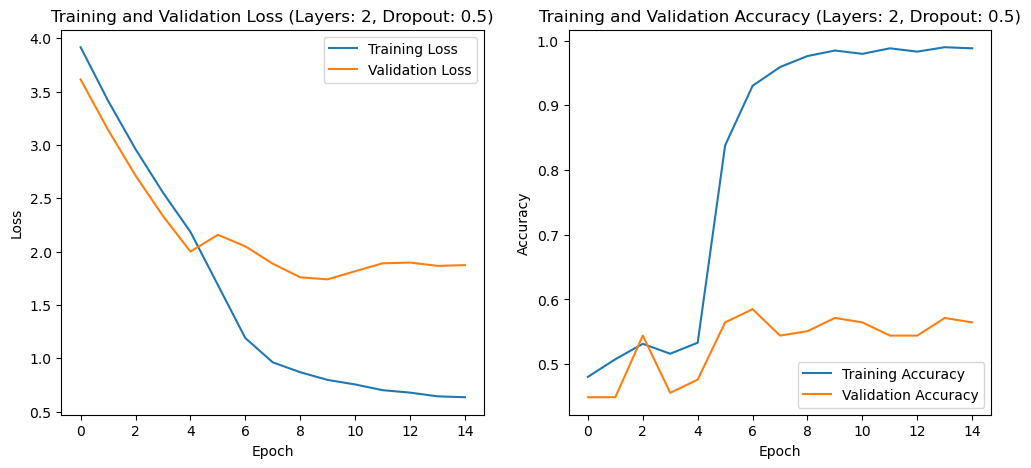

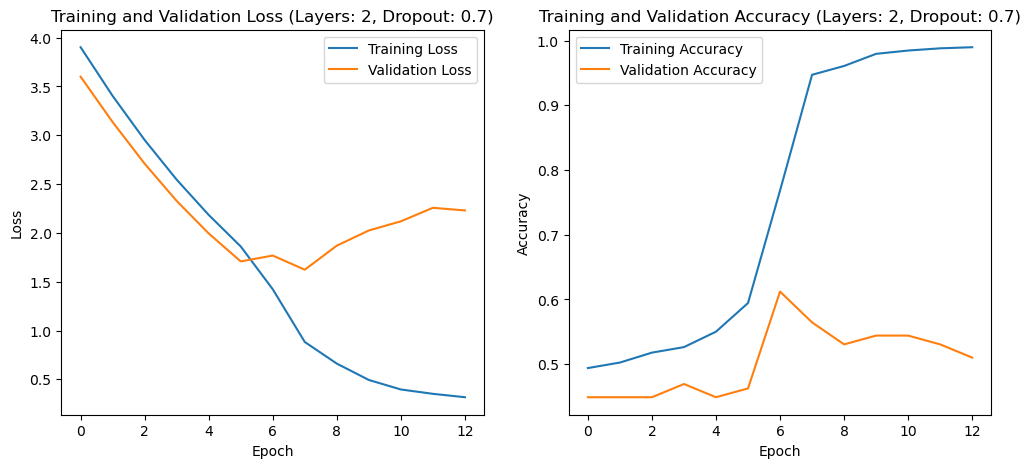

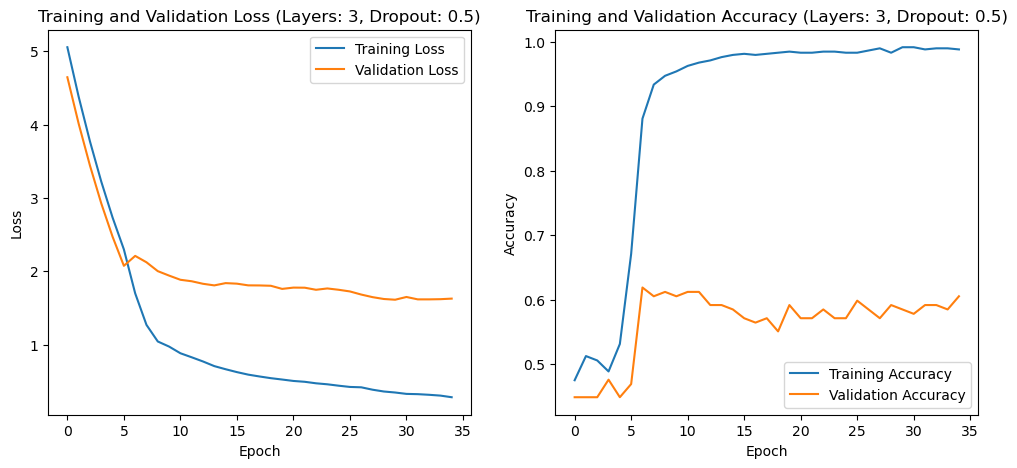

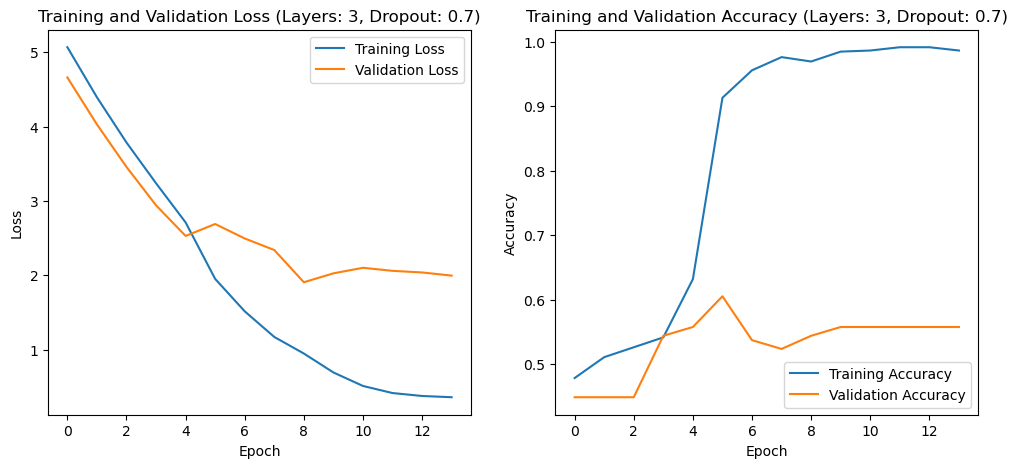

In [29]:
# Model configuration
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 128
regularization = l1_l2(l1=0.001, l2=0.001)  # Combined L1 and L2 regularization

# Hyperparameter sets
layers_options = [2, 3]
dropout_options = [0.5, 0.7]

best_acc = 0
best_params = {}
history_records = []

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

for layers in layers_options:
    for dropout_rate in dropout_options:
        print(f"Training with {layers} layers and {dropout_rate} dropout rate")

        model = Sequential()
        model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_seq_length))
        for i in range(layers):
            return_sequences = i < layers - 1
            model.add(LSTM(64, return_sequences=return_sequences, kernel_regularizer=regularization))
            model.add(Dropout(dropout_rate))
        
        model.add(Dense(1, activation='sigmoid'))

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                            validation_split=0.2, callbacks=[early_stopping, reduce_lr])

        history_records.append((layers, dropout_rate, history))

        test_loss, test_acc = model.evaluate(X_test, y_test)
        print(f'Test Accuracy: {test_acc}')

        if test_acc > best_acc:
            best_acc = test_acc
            best_params = {'layers': layers, 'dropout': dropout_rate}

print(f"Best performing model: {best_params} with accuracy {best_acc}")

for layers, dropout_rate, history in history_records:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# BiLSTM

Training with 2 layers and 0.2 dropout rate
Epoch 1/30
10/10 [==============================] - 13s 310ms/step - loss: 9.0548 - accuracy: 0.4838 - val_loss: 8.2876 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - 1s 69ms/step - loss: 7.7433 - accuracy: 0.7359 - val_loss: 7.1116 - val_accuracy: 0.5646 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - 1s 73ms/step - loss: 6.4595 - accuracy: 0.9114 - val_loss: 6.0816 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 4/30
10/10 [==============================] - 1s 76ms/step - loss: 5.1725 - accuracy: 0.9625 - val_loss: 5.1861 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 5/30
10/10 [==============================] - 1s 74ms/step - loss: 4.2325 - accuracy: 0.9744 - val_loss: 4.3758 - val_accuracy: 0.5918 - lr: 0.0010
Epoch 6/30
10/10 [==============================] - 1s 73ms/step - loss: 3.4886 - accuracy: 0.9676 - val_loss: 3.6911 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 7/30
10/10 [============

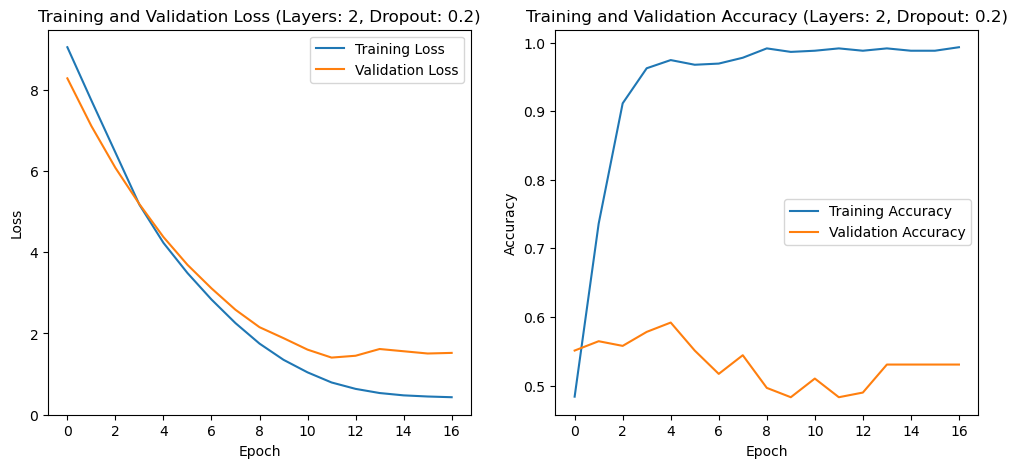

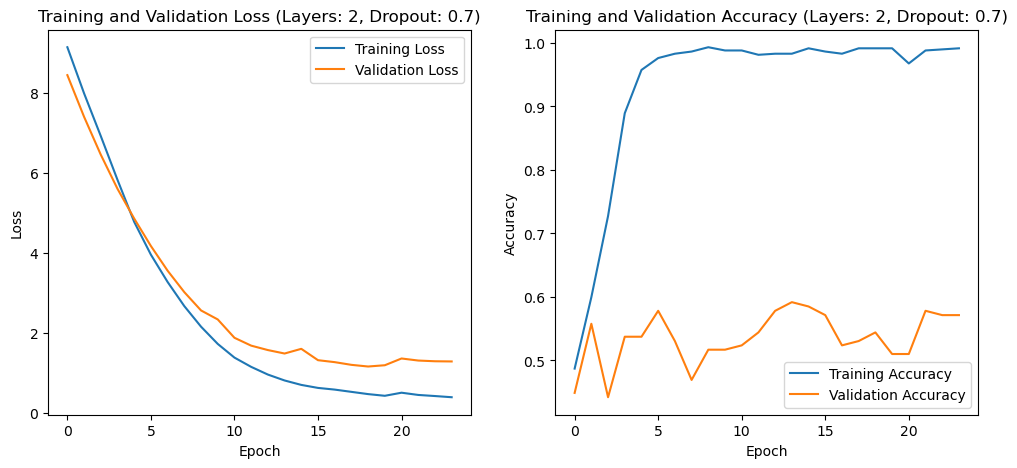

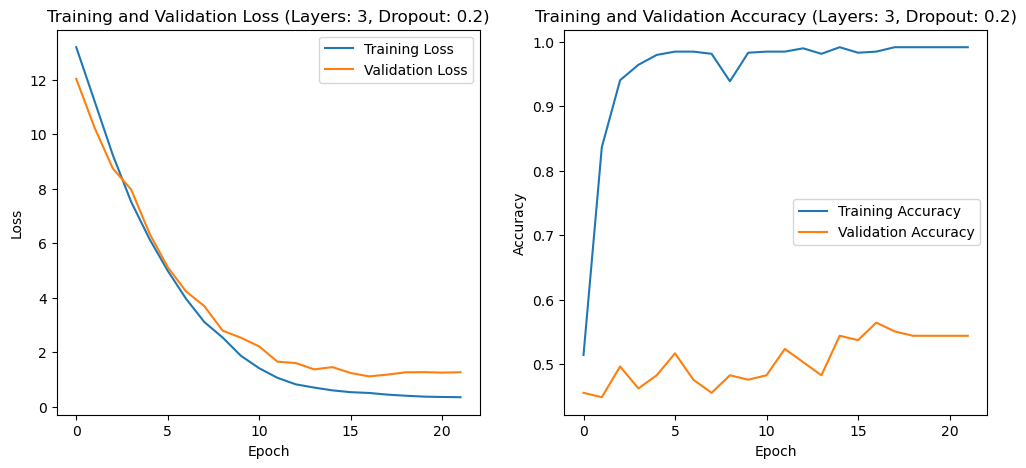

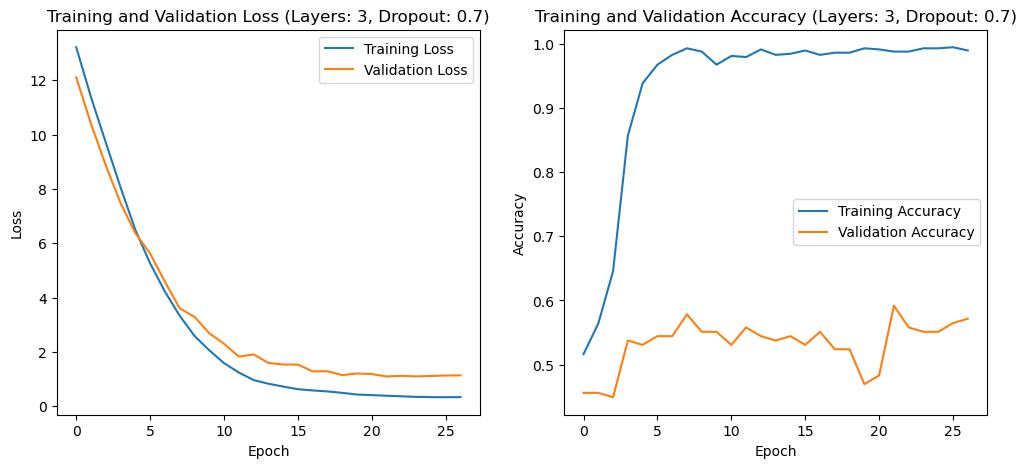

In [30]:
# Model configuration
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 128
reg = l1_l2(l1=0.001, l2=0.001)  # Using both L1 and L2 regularization to prevent overfitting

# Hyperparameter sets
layers_options = [2, 3]
dropout_options = [0.2, 0.7]

best_acc = 0
best_params = {}
history_records = []

# Defining early stopping and reduce learning rate on plateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

for layers in layers_options:
    for dropout_rate in dropout_options:
        print(f"Training with {layers} layers and {dropout_rate} dropout rate")

        model = Sequential()
        model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_seq_length))
        model.add(BatchNormalization())

        for i in range(layers):
            return_sequences = i < layers - 1
            model.add(Bidirectional(LSTM(64, return_sequences=return_sequences, kernel_regularizer=reg)))
            model.add(Dropout(dropout_rate))

        model.add(Dense(1, activation='sigmoid', kernel_regularizer=reg))

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train, y_train, epochs=30, batch_size=64, 
                            validation_split=0.2, callbacks=[early_stopping, reduce_lr])

        history_records.append((layers, dropout_rate, history))

        test_loss, test_acc = model.evaluate(X_test, y_test)
        print(f'Test Accuracy: {test_acc}')

        if test_acc > best_acc:
            best_acc = test_acc
            best_params = {'layers': layers, 'dropout': dropout_rate}

print(f"Best performing model: {best_params} with accuracy {best_acc}")

for layers, dropout_rate, history in history_records:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# BiLSTM using Word2Vec Embeddings

Training with 3 layers and 0.7 dropout rate
Epoch 1/30
10/10 [==============================] - 20s 615ms/step - loss: 13.2127 - accuracy: 0.4974 - val_loss: 12.0585 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - 1s 127ms/step - loss: 11.3219 - accuracy: 0.5077 - val_loss: 10.2789 - val_accuracy: 0.4354 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - 1s 102ms/step - loss: 9.6030 - accuracy: 0.4957 - val_loss: 8.6621 - val_accuracy: 0.4558 - lr: 0.0010
Epoch 4/30
10/10 [==============================] - 1s 121ms/step - loss: 8.0516 - accuracy: 0.5026 - val_loss: 7.2045 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 5/30
10/10 [==============================] - 1s 129ms/step - loss: 6.6557 - accuracy: 0.5468 - val_loss: 5.9058 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 6/30
10/10 [==============================] - 1s 95ms/step - loss: 5.4216 - accuracy: 0.5349 - val_loss: 4.7688 - val_accuracy: 0.4490 - lr: 0.0010
Epoch 7/30
10/10 [====

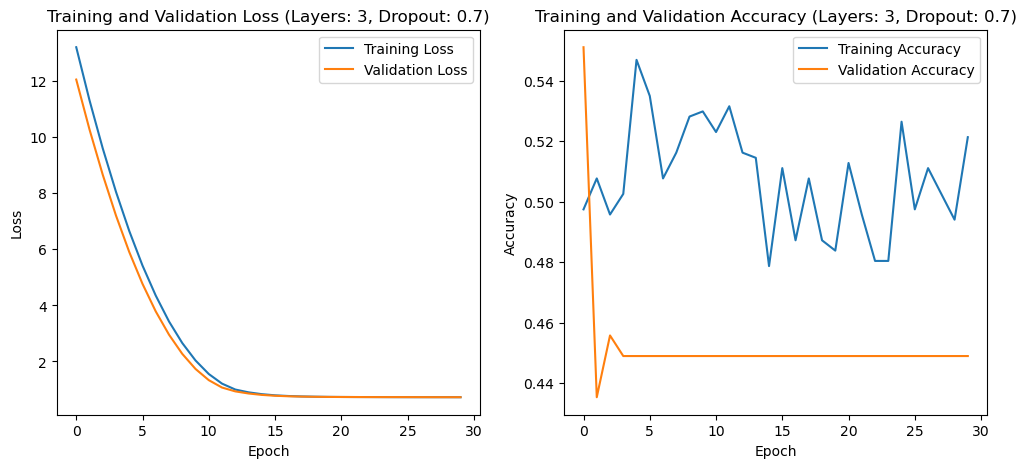

In [31]:
from gensim.models import Word2Vec
import numpy as np

# Assuming df['Tokenized'] contains the tokenized text
all_words = [word for tokens in df['Tokenized'] for word in tokens]
unique_words = set(all_words)

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['Tokenized'], vector_size=128, window=5, min_count=1)

# Create an embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 128))  # Using 128 for the Word2Vec vector size
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Model configuration
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 128
reg = l1_l2(l1=0.001, l2=0.001)  # Using both L1 and L2 regularization to prevent overfitting

# Hyperparameter sets
layers_options = [3]
dropout_options = [0.7]

best_acc = 0
best_params = {}
history_records = []

# Defining early stopping and reduce learning rate on plateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

for layers in layers_options:
    for dropout_rate in dropout_options:
        print(f"Training with {layers} layers and {dropout_rate} dropout rate")

        model = Sequential()
        model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=128,
                    weights=[embedding_matrix],
                    input_length=max_seq_length,
                    trainable=False))  # Set trainable to False to keep the embeddings fixed
        model.add(BatchNormalization())

        for i in range(layers):
            return_sequences = i < layers - 1
            model.add(Bidirectional(LSTM(64, return_sequences=return_sequences, kernel_regularizer=reg)))
            model.add(Dropout(dropout_rate))

        model.add(Dense(1, activation='sigmoid', kernel_regularizer=reg))

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train, y_train, epochs=30, batch_size=64, 
                            validation_split=0.2, callbacks=[early_stopping, reduce_lr])

        history_records.append((layers, dropout_rate, history))

        test_loss, test_acc = model.evaluate(X_test, y_test)
        print(f'Test Accuracy: {test_acc}')

        if test_acc > best_acc:
            best_acc = test_acc
            best_params = {'layers': layers, 'dropout': dropout_rate}

for layers, dropout_rate, history in history_records:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# BiLSTM using Glove Embeddings

In [32]:
# Concatenate all tokenized texts into a single string
corpus = '\n'.join([' '.join(tweet) for tweet in df['Tokenized']])

# Save this string to a text file
with open('corpus.txt', 'w', encoding='utf-8') as file:
    file.write(corpus)

In [ ]:
import numpy as np
import os

glove_path = 'glove.txt'

# Load GloVe embeddings
embeddings_index = {}
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare GloVe embedding matrix
embedding_matrix = np.zeros((vocab_size, embed_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embed_dim,
                    weights=[embedding_matrix],
                    input_length=max_seq_length,
                    trainable=False))  # Set trainable to False to not update the embeddings
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.7))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=[early_stopping, reduce_lr])

for layers, dropout_rate, history in history_records:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# BiLSTM using FastText Embeddings

Training with 3 layers and 0.7 dropout rate
Epoch 1/30
10/10 [==============================] - 36s 480ms/step - loss: 13.1385 - accuracy: 0.4634 - val_loss: 11.9178 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 2/30
10/10 [==============================] - 0s 35ms/step - loss: 11.1274 - accuracy: 0.4821 - val_loss: 10.0268 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 3/30
10/10 [==============================] - 0s 35ms/step - loss: 9.3151 - accuracy: 0.5009 - val_loss: 8.3281 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 4/30
10/10 [==============================] - 0s 38ms/step - loss: 7.6928 - accuracy: 0.5128 - val_loss: 6.8153 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 5/30
10/10 [==============================] - 0s 42ms/step - loss: 6.2567 - accuracy: 0.4855 - val_loss: 5.4883 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 6/30
10/10 [==============================] - 0s 38ms/step - loss: 5.0029 - accuracy: 0.5060 - val_loss: 4.3378 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 7/30
10/10 [========

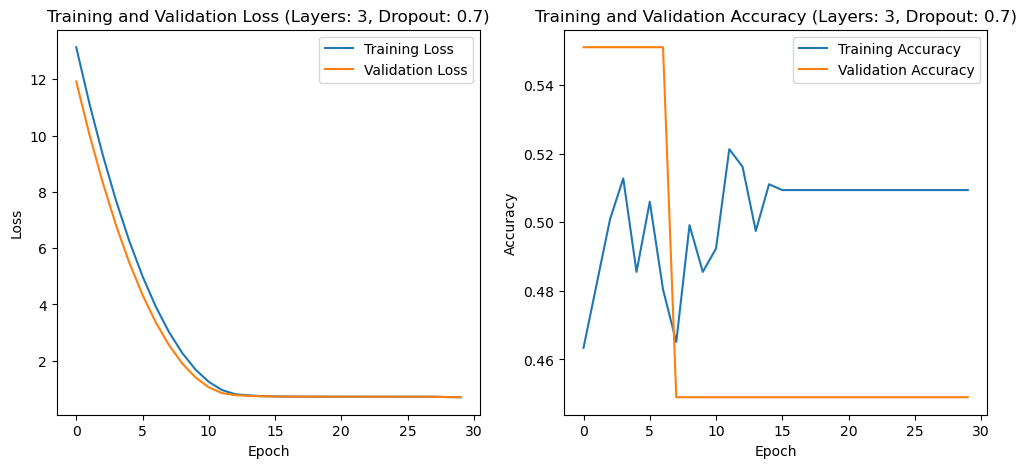

In [ ]:
from gensim.models import FastText
import numpy as np

all_words = [word for tokens in df['Tokenized'] for word in tokens]
unique_words = set(all_words)

# Train FastText model
fasttext_model = FastText(sentences=df['Tokenized'], vector_size=128, window=5, min_count=1)

# Create an embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 128))  # Using 128 for the FastText vector size
for word, i in tokenizer.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]

vocab_size = len(tokenizer.word_index) + 1
embed_dim = 128
reg = l1_l2(l1=0.001, l2=0.001)  # Using both L1 and L2 regularization to prevent overfitting

# Hyperparameter sets
layers_options = [3]
dropout_options = [0.7]

best_acc = 0
best_params = {}
history_records = []

# Defining early stopping and reduce learning rate on plateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

for layers in layers_options:
    for dropout_rate in dropout_options:
        print(f"Training with {layers} layers and {dropout_rate} dropout rate")

        model = Sequential()
        model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=128,
                    weights=[embedding_matrix],
                    input_length=max_seq_length,
                    trainable=False))
        model.add(BatchNormalization())

        for i in range(layers):
            return_sequences = i < layers - 1
            model.add(Bidirectional(LSTM(64, return_sequences=return_sequences, kernel_regularizer=reg)))
            model.add(Dropout(dropout_rate))

        model.add(Dense(1, activation='sigmoid', kernel_regularizer=reg))

        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        history = model.fit(X_train, y_train, epochs=30, batch_size=64, 
                            validation_split=0.2, callbacks=[early_stopping, reduce_lr])

        history_records.append((layers, dropout_rate, history))

        test_loss, test_acc = model.evaluate(X_test, y_test)
        print(f'Test Accuracy: {test_acc}')

        if test_acc > best_acc:
            best_acc = test_acc
            best_params = {'layers': layers, 'dropout': dropout_rate}

for layers, dropout_rate, history in history_records:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Layers: {layers}, Dropout: {dropout_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# BiLSTM using ELMO Embeddings

In [ ]:
!pip install bilm

In [ ]:
# Collecting all unique words in the dataset
all_words = set()
for tokens in df['Tokenized']:
    all_words.update(tokens)

vocab_file_path = 'vocab.txt'
with open(vocab_file_path, 'w', encoding='utf-8') as file:
    for word in all_words:
        file.write(word + '\n')

print(f"Vocabulary file created with {len(all_words)} unique words at {vocab_file_path}")

Vocabulary file created with 4922 unique words at vocab.txt


In [ ]:
from bilm.training import train, load_options_latest_checkpoint, load_vocab
from bilm.data import LMDataset, BidirectionalLMDataset
import json

train_prefix = 'corpus.txt'

vocab_file = 'vocab.txt'

save_dir = r'D:\Users\Nadeem\Desktop\BSDS\Semester 8\NLP\Assignment 3'

batch_size = 128
n_gpus = 0

options = {
    'bidirectional': True,

    'char_cnn': {
        'activation': 'relu',
        'embedding': {'dim': 16},
        'filters': [
            [1, 32],
            [2, 32],
            [3, 64],
            [4, 128],
            [5, 256],
            [6, 512],
            [7, 1024]
        ],
        'max_characters_per_token': 50,
        'n_characters': 262,
        'n_highway': 2,
    },

    'dropout': 0.1,
    'lstm': {
        'cell_clip': 3,
        'dim': 4096,
        'n_layers': 2,
        'proj_clip': 3,
        'projection_dim': 512,
        'use_skip_connections': True,
    },

    'all_clip_norm_val': 10.0,
    'n_epochs': 10,  # Number of training epochs
    'n_train_tokens': 10000000,  # Approximate number of tokens in training data
    'batch_size': batch_size,
    'n_tokens_vocab': 100000,  # Size of the vocabulary
    'unroll_steps': 20,  # Sequence length
    'n_negative_samples_batch': 8192,
}

# Save the options
with open(os.path.join(save_dir, 'options.json'), 'w') as fout:
    json.dump(options, fout)

vocab = load_vocab(vocab_file, 50)
tf_save_dir = save_dir
tf_log_dir = save_dir

train(options, vocab, tf_save_dir, tf_log_dir, restart_ckpt_file=None)